In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os

# Vérifiez la version de TensorFlow et la disponibilité du GPU
print(tf.__version__)
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())
train_data = '../Desktop/training_set/'

2.15.0
The following GPU devices are available: 


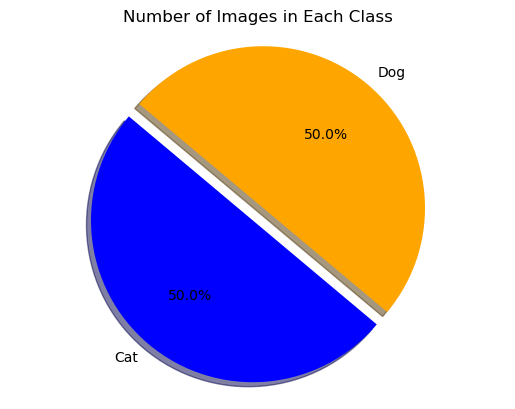

In [5]:
import os

cat_dir = '../Desktop/training_set/cats/'
dog_dir = '../Desktop/training_set/dogs/'

num_cat_images = len(os.listdir(cat_dir))
num_dog_images = len(os.listdir(dog_dir))


labels = ['Cat', 'Dog']
sizes = [num_cat_images, num_dog_images]
colors = ['blue', 'orange']
explode = (0, 0.1)  

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Number of Images in Each Class')
plt.show()


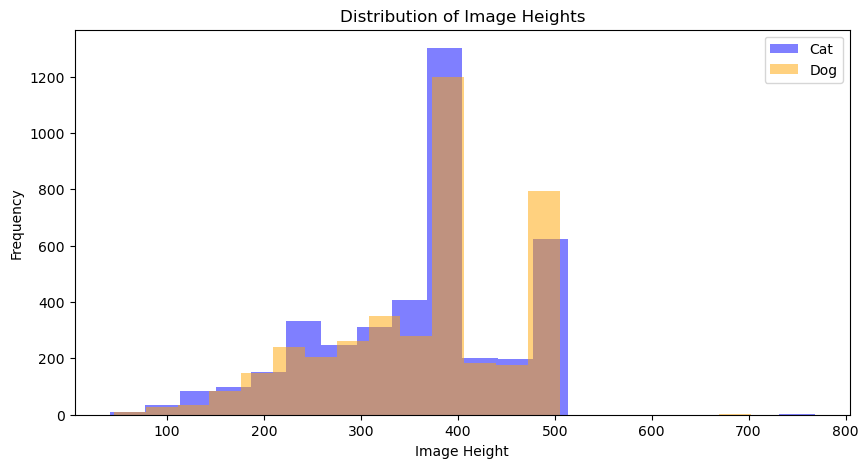

In [6]:
import cv2

image_sizes_cat = [cv2.imread(os.path.join(cat_dir, img)).shape[:2] for img in os.listdir(cat_dir)]
image_sizes_dog = [cv2.imread(os.path.join(dog_dir, img)).shape[:2] for img in os.listdir(dog_dir)]

plt.figure(figsize=(10, 5))
plt.hist([size[0] for size in image_sizes_cat], bins=20, color='blue', alpha=0.5, label='Cat')
plt.hist([size[0] for size in image_sizes_dog], bins=20, color='orange', alpha=0.5, label='Dog')
plt.xlabel('Image Height')
plt.ylabel('Frequency')
plt.title('Distribution of Image Heights')
plt.legend()
plt.show()


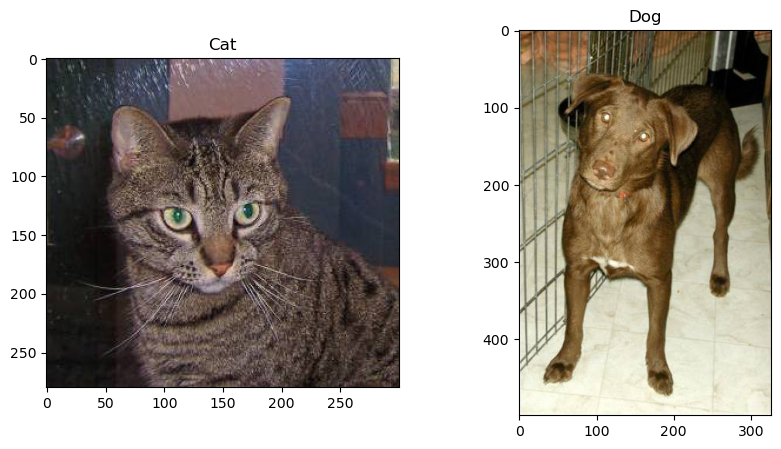

In [8]:
import matplotlib.image as mpimg

cat_img = os.path.join(cat_dir, os.listdir(cat_dir)[0])
dog_img = os.path.join(dog_dir, os.listdir(dog_dir)[0])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(cat_img))
plt.title('Cat')

plt.subplot(1, 2, 2)
plt.imshow(mpimg.imread(dog_img))
plt.title('Dog')

plt.show()


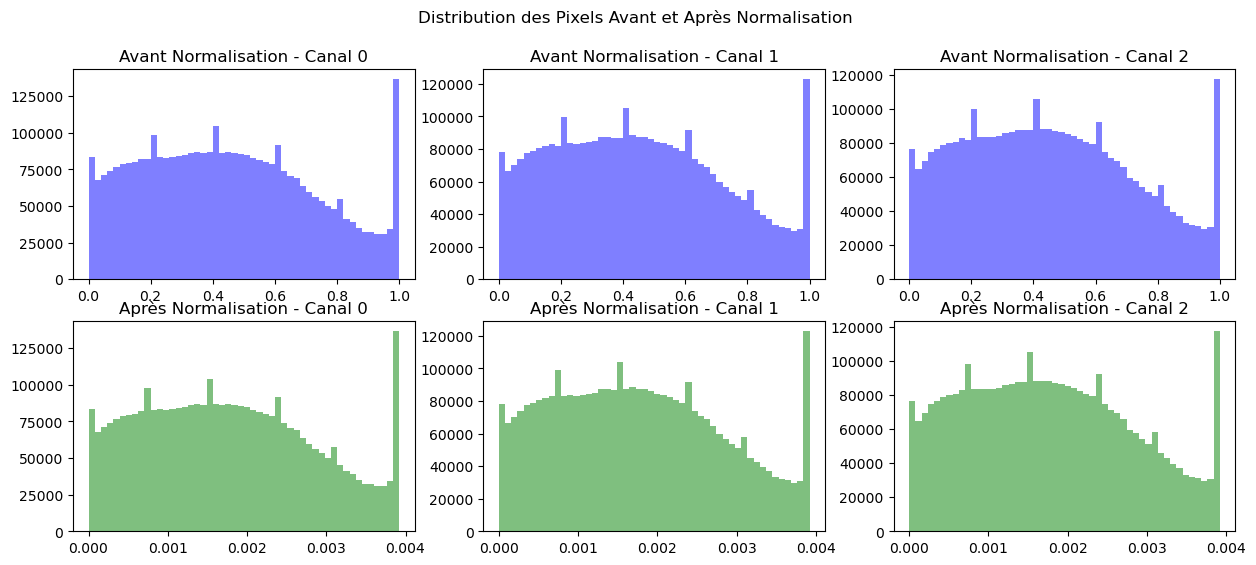

In [14]:
import matplotlib.pyplot as plt

def plot_pixel_distribution(images, title):
    fig, axs = plt.subplots(2, images.shape[-1], figsize=(15, 6))
    fig.suptitle(title)
    
    for i in range(images.shape[-1]):
        axs[0, i].hist(images[:, :, i].flatten(), bins=50, color='blue', alpha=0.5)
        axs[0, i].set_title(f'Avant Normalisation - Canal {i}')
        
        axs[1, i].hist((images[:, :, i] / 255.0).flatten(), bins=50, color='green', alpha=0.5)
        axs[1, i].set_title(f'Après Normalisation - Canal {i}')
    
    plt.show()

# Charger les images non normalisées
images_unnormalized, _, _ = load_images_from_directory(train_data, augment_data=False)

# Tracer les distributions des pixels avant et après normalisation
plot_pixel_distribution(images_unnormalized, title="Distribution des Pixels Avant et Après Normalisation")


Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


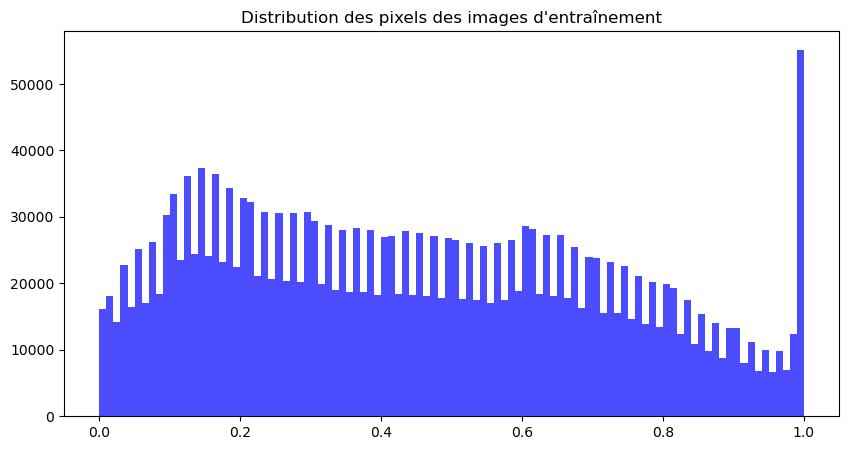

In [22]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Chemins des données
train_data = '../Desktop/training_set/'

# Création de l'instance ImageDataGenerator avec prétraitement des images
datagen = ImageDataGenerator(
    rescale=1.0/255.0,        # Normaliser les pixels
    validation_split=0.2      # Fraction de validation
)

# Chargement des données d'entraînement
train_generator = datagen.flow_from_directory(
    train_data,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',      # Mode de classe binaire pour chat/chien
    subset='training'         # Utilisation pour l'entraînement
)

# Chargement des données de validation
validation_generator = datagen.flow_from_directory(
    train_data,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',      # Mode de classe binaire pour chat/chien
    subset='validation'       # Utilisation pour la validation
)
# Prendre un lot d'images pour la vérification
sample_images, _ = next(train_generator)
plt.figure(figsize=(10, 5))
plt.hist(sample_images.ravel(), bins=100, color='blue', alpha=0.7)
plt.title("Distribution des pixels des images d'entraînement")
plt.show()

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_rcnn_model(input_shape, num_classes):
    # Entrée du modèle
    input_layer = layers.Input(shape=input_shape)
    
    # Couche de convolution
    conv_layer = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    
    # Couche de max pooling
    pool_layer = layers.MaxPooling2D((2, 2))(conv_layer)
    
    # Couche de convolution supplémentaire
    conv_layer = layers.Conv2D(64, (3, 3), activation='relu')(pool_layer)
    
    # Couche de max pooling supplémentaire
    pool_layer = layers.MaxPooling2D((2, 2))(conv_layer)
    
    # Aplatir les caractéristiques en un vecteur
    flatten_layer = layers.Flatten()(pool_layer)
    
    # Couche dense
    dense_layer = layers.Dense(64, activation='relu')(flatten_layer)
    
    # Couche de sortie avec softmax pour la classification
    output_layer = layers.Dense(num_classes, activation='softmax')(dense_layer)
    
    # Créer le modèle
    model = models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

# Définir la forme de l'entrée et le nombre de classes
input_shape = (150, 150, 3)  # Adapté à la taille des images
num_classes = 2  # Par exemple, pour les classes "chat" et "chien"

# Créer le modèle RCNN
model = create_rcnn_model(input_shape, num_classes)

# Compiler le modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 82944)             0   

In [25]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Epoch 1/10
200/200 [==============================] - 95s 466ms/step - loss: 0.6768 - accuracy: 0.5769 - val_loss: 0.6225 - val_accuracy: 0.6356
Epoch 2/10
200/200 [==============================] - 70s 347ms/step - loss: 0.5710 - accuracy: 0.7044 - val_loss: 0.5754 - val_accuracy: 0.7050
Epoch 3/10
200/200 [==============================] - 70s 349ms/step - loss: 0.4615 - accuracy: 0.7798 - val_loss: 0.5646 - val_accuracy: 0.7256
Epoch 4/10
200/200 [==============================] - 71s 356ms/step - loss: 0.3438 - accuracy: 0.8458 - val_loss: 0.5895 - val_accuracy: 0.7225
Epoch 5/10
200/200 [==============================] - 72s 361ms/step - loss: 0.2044 - accuracy: 0.9203 - val_loss: 0.6481 - val_accuracy: 0.7375
Epoch 6/10
200/200 [==============================] - 71s 352ms/step - loss: 0.1033 - accuracy: 0.9648 - val_loss: 0.9337 - val_accuracy: 0.7081
Epoch 7/10
200/200 [==============================] - 72s 358ms/step - loss: 0.0606 - accuracy: 0.9814 - val_loss: 1.1715 - val_ac

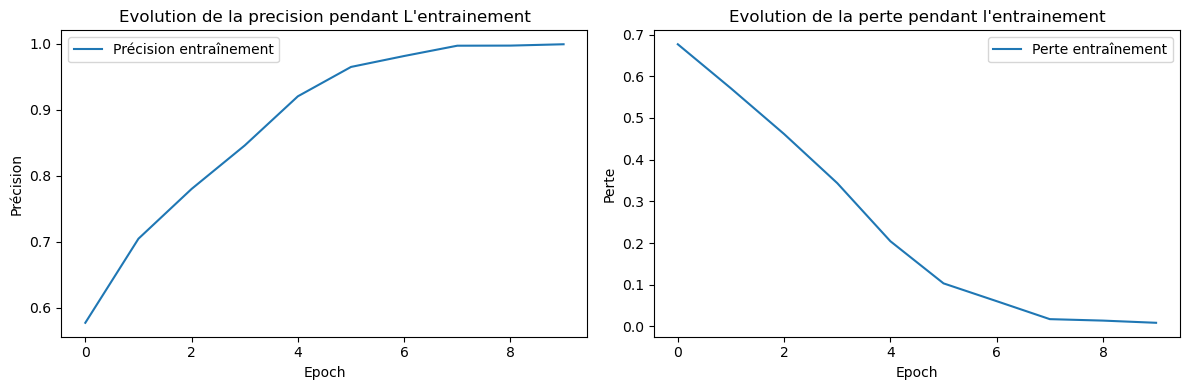

In [33]:
import matplotlib.pyplot as plt

# Afficher les courbes de précision et de perte sur la même figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Courbe de précision
ax1.plot(history.history['accuracy'], label='Précision entraînement')
ax1.set_title("Evolution de la precision pendant L'entrainement")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Précision')
ax1.legend()

# Courbe de perte
ax2.plot(history.history['loss'], label='Perte entraînement')
ax2.set_title("Evolution de la perte pendant l'entrainement")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perte')
ax2.legend()

plt.tight_layout()
plt.show()


In [38]:
# Sauvegarde du modèle
model.save('../Desktop/training_set/cat_dog_classifier.keras')
lm=load_model('../Desktop/training_set/cat_dog_classifier.keras')

In [51]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np

# Chemin de l'image de test
image_test = '../Desktop/training_set/T_P1_16_Egayer-les-sorties-une-personne-agee.jpg'

def predict_image(image_path, model):
    # Charger et redimensionner l'image
    img = Image.open(image_path)
    img = img.resize((150, 150))  # Redimensionner à la taille attendue par le modèle
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Faire une prédiction
    predictions = model.predict(img_array)
    cat_probability = predictions[0][0]
    dog_probability = predictions[0][1]

    # Déterminer la classe prédite
    if cat_probability > dog_probability:
        class_name = 'cat'
        probability = cat_probability
    else:
        class_name = 'dog'
        probability = dog_probability

    # Charger à nouveau l'image originale (non redimensionnée) pour l'affichage
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", size=40)
    # Texte avec classe prédite et probabilité
    text = f"Predicted: {class_name} ({probability:.2f})"
    
    # Dessiner le texte sur l'image
    draw.text((17, 15), text, fill=(255, 255, 215))
    img.show()

# Exemple de prédiction
predict_image(image_test, lm)


1/1 [==============================] - 0s 30ms/step
